# Projet phylogénétique
Théophile Sanchez (theophile.sanchez@inria.fr) - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'*homotherium* (*scimitar toothed tigers*) et *Miracinonyx trumani* (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN anciennes de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Notez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites très attention au plagiat, d'après les règles de l'université vous risquez beaucoup s'il est avéré ! 

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [1]:
import re

def parse_fasta(file):
    # Patterns matching
    PNAME = "\s*>\s*([\w\W]*[\w\S]+){1}\s*"
    PSEQ = "\s*([ATGC-]+){1}\s*"
    PARENTHESIS = re.compile("[()]")
    res = {}
    name = ""
    with open(file, "r") as fo:
        fasta_lines = fo.readlines()
        for line in fasta_lines:
            match = re.search(PNAME, line)
            # Nom de l'espèce
            if match != None:
                # On enlève les parenthèses car elles ne sont
                # pas admises pour le format newick
                name = PARENTHESIS.sub("", match.group(1))
                res[name] = ""
            # Séquence ADN
            else:
                match = re.search(PSEQ, line)
                if match != None and name != "":
                    res[name] += match.group(1)
        return res

In [2]:
fasta = parse_fasta("cat_dna.fasta")
print(fasta)

{'Sabertooth DNA Smilodon': 'CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGCTCCTTATTAGGAGTGTGCTTAATCTTACAAATCCTCACTGGCTTATTTCTAGCCATACATTATACACCAGATACAACAACCGCCTTCTCATCAGTTACCCACATTTGCCGTGATGAATTACGGCTGAATTATCCGATATATACGCCAATGGAGCTTCCATATTCTTCATCTGCCTATATATACATGTAGGTCGAGCATATACTAC', 'Homotherium DNA': 'CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCTCCAACATCTCAGCATGATGAAACTTCGGATCCCTACTAGGCATTTGCCTAATTCTTCAAATCCTCACAGGCTTATTCCTAGCCATACACTACACATCAGACACAACAACTGCTTCTCATCAATCGCCCATATTTGCCGTGACGTAAATTATGGTTGAATTATCCGATATATACACGCCAATGGAGCCTCTATATTCTTCCTGTCTATACCTACATGTAGCTCGAGAATTTATTAC', 'American Cat DNA Miracinonyx': 'CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGTTCCCTATAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTCTTCCTGGCTATACAACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATCTGTCGTGACGTCAATTACGGCTGAATTATTCGGTATTACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCACGTAGGGCGAGGAATATATTAC', 'Spotted Hyena DNA': 'CTCATTAAAATTATCAACAAATCATTCATTGACCTCCCCACCCCA

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Il est aussi possible qu'une délétion ne soit pas une mutation, mais en réalité dû à un mauvais séquençage ou à la dégradation ADN comme c'est souvent le cas pour le séquençage d'ADN d'espèces disparues. 

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [3]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [4]:
def compute_score(A, B):
    N = len(A)
    M = len(B)
    res = 0
    if N == M:
        for i in range(0, N):
            res += similarity_matrix.score(A[i], B[i])
        return res
    else:
        raise ValueError(f"len(al1) = {N} != len(al2) = {M}")

In [5]:
A1 = ("-ACTCCTGA", "ATCTCGTGA")
A2 = ("A-CTCCTGA", "ATCTCGTGA")
A3 = ("AC-TCCTGA", "ATCTCGTGA")
assert(compute_score(A1[0], A1[1]) == -5-4+7+8+7-5+8+9+10)
assert(compute_score(A2[0], A2[1]) == 10-5+7+8+7-5+8+9+10)
assert(compute_score(A3[0], A3[1]) == 10-3-5+8+7-5+8+9+10)

------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [6]:
class NeedlmanWunsh:
    
    def __init__(self, A, B, score_matrix="dna_matrix"):
        '''
        @param A, B: séquences str
        @param score_matrix: nom fichier de matrice de score
        '''
        
        self.A = A
        self.B = B
        self.s = SimilarityMatrix(score_matrix)
        self.n = len(self.A)
        self.m = len(self.B)
        
        # Initialisation matrice de score
        self.M = np.zeros((self.n + 1, self.m + 1), dtype=int)
        # Boucles car score pas forcément constant
        for i in range(1, self.n + 1):
            self.M[i][0] = self.s.score(self.A[i - 1], '-') + self.M[i - 1][0]
        for j in range(1, self.m + 1):
            self.M[0][j] = self.s.score(self.B[j - 1], '-') + self.M[0][j - 1]
        
        # Initialisation matrice de Traceback
        self.T = np.zeros((self.n + 1, self.m + 1), dtype=str)
        self.T[0][0] = 'o'
        self.T[1:self.n + 1][:,0] = 'u'
        self.T[0][1:self.m + 1] = 'l'

    # Fonction récursive terminale pour remonter
    # le chemin de la matrice Traceback
    def __traceback(self, n, m, res):
        # ATTENTION: n, m sont des arguments pas des attributs
        current = self.T[n][m]
        if current == 'o':
            return res
        else:
            if current == 'd':
                res = (self.A[n - 1] + res[0], self.B[m - 1] + res[1])
                return self.__traceback(n - 1, m - 1, res)
            elif current == 'l':
                res = ('-' + res[0], self.B[m - 1] + res[1])
                return self.__traceback(n, m - 1, res)
            elif current == 'u':
                res = (self.A[n - 1] + res[0], '-' + res[1])
                return self.__traceback(n - 1, m, res)
            else:
                raise ValueError(f"current = {current} impossible value")

    def best_alignment(self):
        '''
        @return: meileur alignement (A', B')
        '''
        
        # Remplissage des matrices M et T
        for i in range(1, self.n + 1):
            for j in range(1, self.m + 1):
                # max(𝑀𝑖−1𝑗−1+𝑠(𝐴𝑖,𝐵𝑗),𝑀𝑖𝑗−1+𝑠(𝐴𝑖,𝑔𝑎𝑝),𝑀𝑖−1𝑗+𝑠(𝐵𝑗,𝑔𝑎𝑝))
                d = ('d', self.M[i - 1][j - 1] + self.s.score(self.A[i - 1], self.B[j - 1]))
                l = ('l', self.M[i][j - 1] + self.s.score(self.A[i - 1], '-'))
                u = ('u', self.M[i - 1][j] + self.s.score(self.B[j - 1], '-'))
                # Maximum selon le score dans [(lettre, score),...]
                res = max([d, l, u], key=lambda x: x[1])
                self.M[i][j] = res[1]
                self.T[i][j] = res[0]
            
        # Traceback
        return self.__traceback(self.n, self.m, ("", ""))

In [7]:
nw = NeedlmanWunsh("ACTCCTGA", "ATCTCGTGA")
best = nw.best_alignment()
assert (best == ("A-CTCCTGA", "ATCTCGTGA"))
print(best)

('A-CTCCTGA', 'ATCTCGTGA')


**Exercice 4 :** Appliquer votre algorithme aux données. Vous remarquerez que Needlman et Wunsch permet d'aligner deux séquences entre elles, or vous devez aligner toute les séquences en même temps. Adapter l'algorithme en faisant au plus simple, seulement les séquences d'ADN anciens ont une longueur différente des autres.

In [8]:
# Exercice annulé par Théophile Sanchez pour cause d'impossibilité de réalisation...

----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, **on ignore les positions alignées à des gaps**. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le phénomène de saturation (un même site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 5 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [9]:
def pdistance(A, B):
    '''
    @param A, B: Séquences str avec len(A) = len(B)
    @return: (nombre de substitutions int, nombre de nucléotides int)
    '''
    repl = 0
    nucl = 0
    NA = len(A)
    NB = len(B)
    if NA != NB: 
        raise ValueError(f"len(A)={NA} != len(B)={NB}")
    for (a, b) in zip(A, B):
        # On ignore les gaps
        if a != '-' and b != '-':
            # Substitution
            if a != b:
                repl += 1
                nucl += 1
            # Match
            else:
                nucl += 1
    return float(repl)/float(nucl)

def compute_distances(fasta, align=False):
    '''
    @param fasta: Dictionnaire nom <-> seq
    @param align: Aligner les séquences si tailles différentes
    @return: matrice des distances entre séquences
    '''
    n = len(fasta)
    if n < 2:
        raise ValueError(f"len(fasta) = {n} < 2 not enough")
    lk = list(fasta.keys())
    # Matrice identité
    M = np.eye(n, dtype=float)
    M[0][0] = 0.
    i = 1 
    j = 0
    # Remplissage du triangle inférieur
    while i < n:
        # Quand diagonale on revient à la ligne
        if M[i][j] == 1.:
            M[i][j] = 0.
            i += 1
            j = 0
        else:
            # Affichage de l'avancement
            print(f"M[{i}][{j}]=Dist({lk[i]}, {lk[j]})")
            # Calcul éventuel de l'alignement
            (A, B) = (fasta[lk[i]], fasta[lk[j]])
            if align:
                nw = NeedlmanWunsh(fasta[lk[i]], fasta[lk[j]])
                (A, B) = nw.best_alignment()
            # Calcul du nombre de substitutions
            M[i][j] = pdistance(A, B)
            j += 1
            
    # Correction de Jukes-Cantor
    return abs(-(3 / 4) * np.log(1 - (4 / 3) * M))

def triu_inf(M):
    '''
    @param M: Matrice triangulaire avec triangle bas et le reste à 0.
    @return: Même matrice mais le triangle haut à inf
    '''
    return M + np.triu(np.full(M.shape, np.inf))

import seaborn as sns
import matplotlib.pyplot as plt

def print_matrix(M, fasta):
    N = len(fasta)
    plt.figure(figsize=(N, N))
    sns.heatmap(M, annot=True, xticklabels=fasta, yticklabels=fasta)

In [10]:
M1 = compute_distances(fasta, align=True)

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

La p-distance est exprimée entre [0;1]. Plus elle est proche de 0, plus les séquences sont ressemblantes. Plus elle est proche de 1 plus les séquences sont différentes. La matrice-triangle affichée donne les p-distances de chacune des séquences du fichier fasta par comparaison deux à deux.

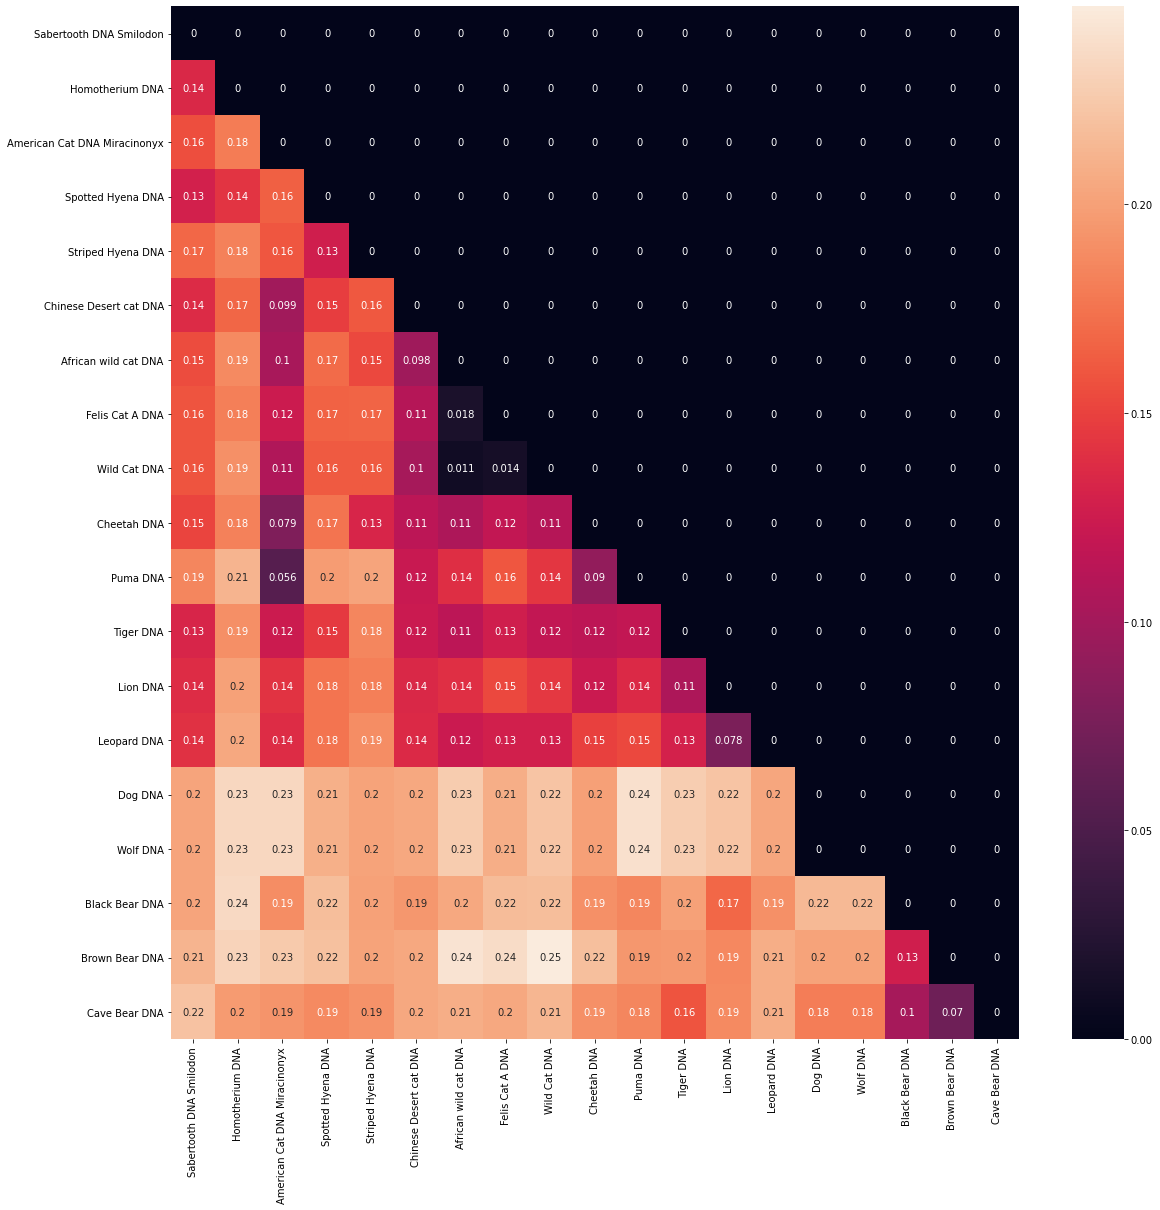

In [11]:
print_matrix(M1, fasta)

In [12]:
fasta_align = parse_fasta("msa_cat_dna.fasta")
print(fasta_align)

{'Sabertooth DNA Smilodon': 'CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGCTCCTTATTAGGAGTGTGCTTAATCTTACAAATCCTCACTGGCTTATTTCTAGCCATACATTATACACCAGATACAACAACCGCCTTCTCATCAGTTACCCACATTTGCCGTGATGA--ATTACGGCTGAATTATCCGAT--ATATACGCCAATGGAGCTTCCATATTCTTCATCTGCCTATATATACATGTAGGTCGAGCATATACTAC', 'Homotherium DNA': 'CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCTCCAACATCTCAGCATGATGAAACTTCGGATCCCTACTAGGCATTTGCCTAATTCTTCAAATCCTCACAGGCTTATTCCTAGCCATACACTACACATCAGACACAACAACTGC-TTCTCATCAATCGCCCATATTTGCCGTGACGTAAATTATGGTTGAATTATCCGATATATACACGCCAATGGAGCCTCTATATTCTTCCTGTCTATACCT--ACATGTAGCTCGAGAATTTATTAC', 'American Cat DNA Miracinonyx': 'CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGTTCCCTA-TAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTCTTCCTGGCTATA--CAACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATCTGTCGTGACGTCAATTACGGCTGAATTATTCGGTAT-TACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCACGTAGGGCGAGAATATATTAC', 'Spotted Hyena DNA': 'CTCATTAAAATTATCAACAAATCATTCATTGACCT

In [13]:
M2 = compute_distances(fasta_align, align=False)

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

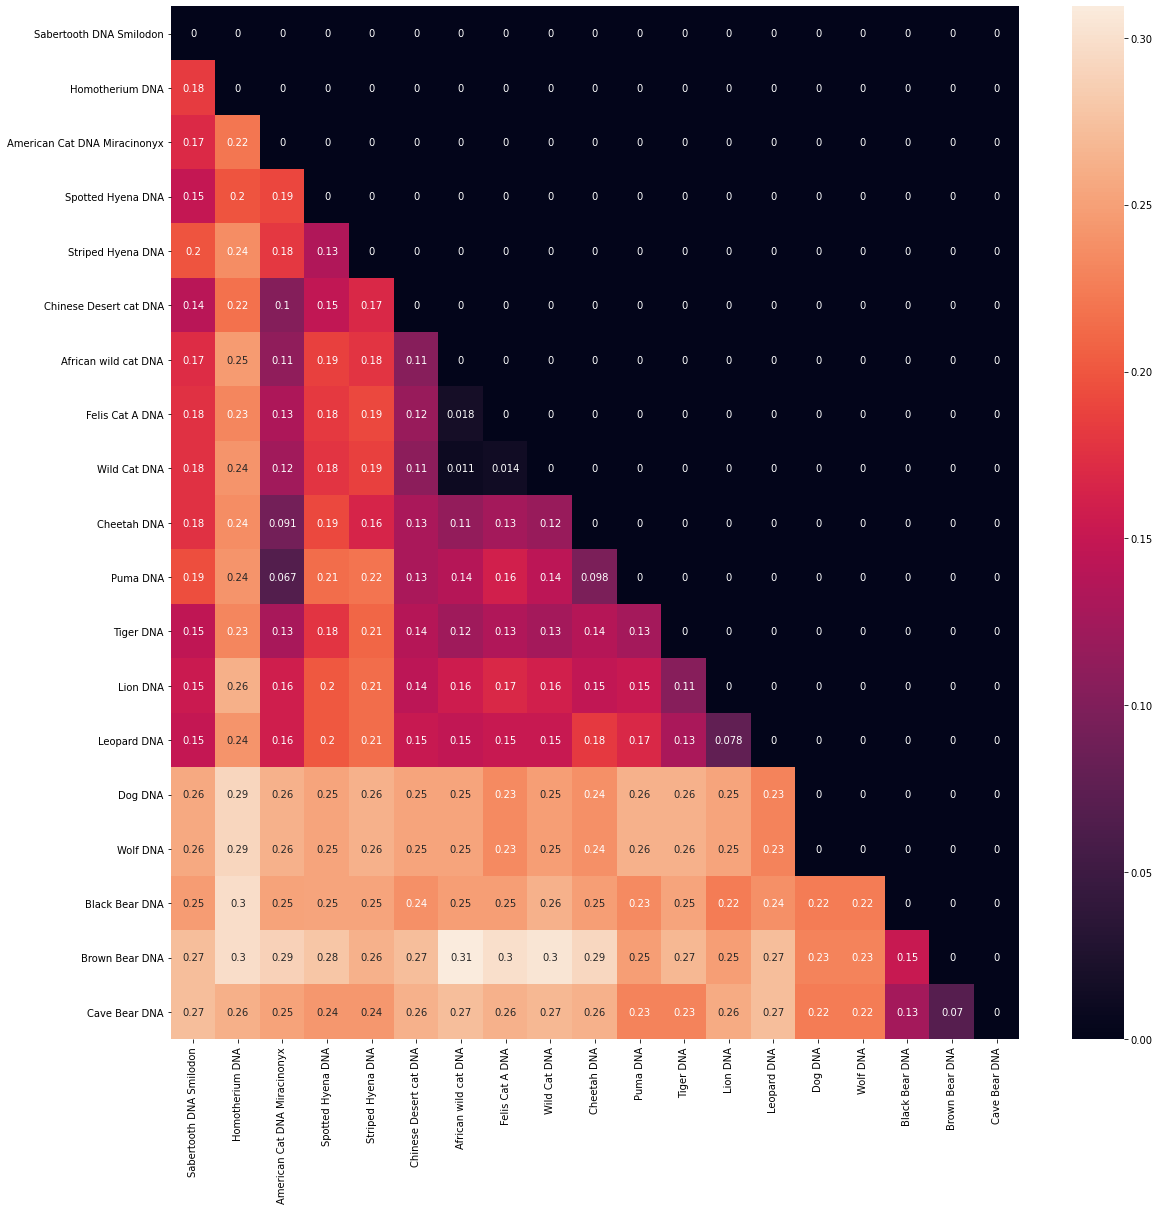

In [14]:
print_matrix(M2, fasta_align)

In [15]:
assert (fasta['Dog DNA'] == fasta['Wolf DNA'])
assert (fasta_align['Dog DNA'] == fasta_align['Wolf DNA'])

On remarque que 2 des séquences sont strictement identiques !

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique de la protéine cytochrome b. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

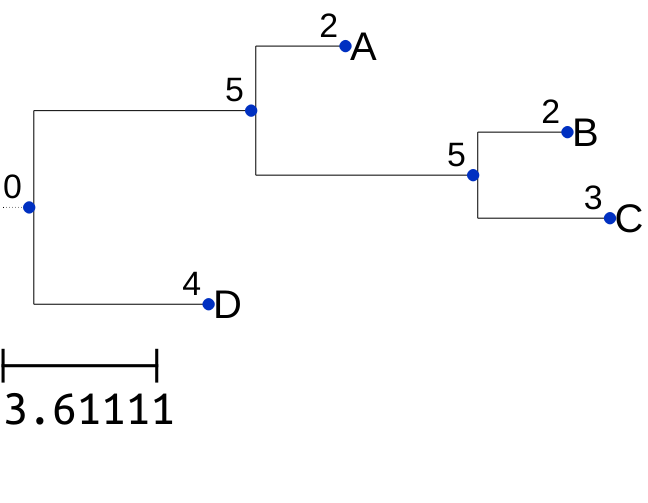

In [16]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

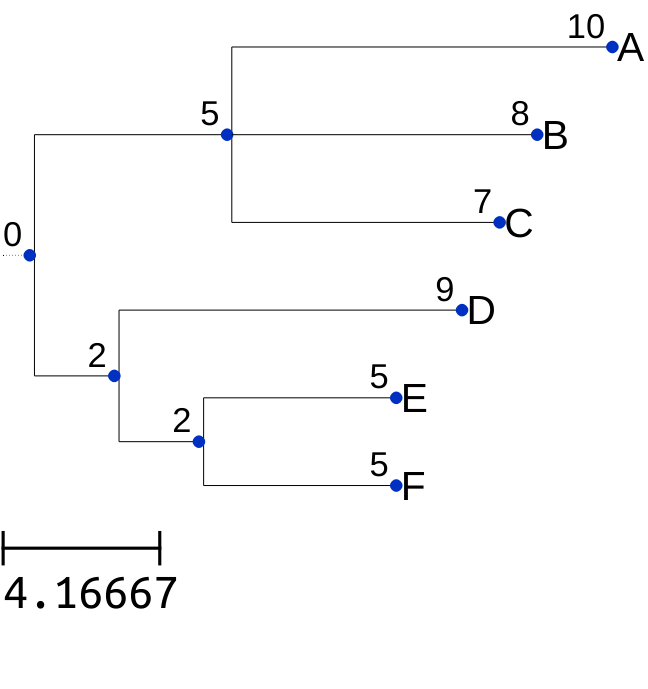

In [17]:
newick_tree = '((A:10, B:8, C:7):5, (D:9, (E:5, F:5):2):2);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 7 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse : Les espèces A, B et C sont toutes apparentées au même ancêtre commun. En principe ce n'est pas possible, car un ancêtre commun peut se diviser en seulement 2 sous-espèces habituellement, du fait d'un évènement à un instant t. Il est en effet, très rare qu'un même envènement conduise à une telle spéciation ternaire. Mais, il est également possible qu'on cache un ancêtre commun entre B et C qui sont les 2 espèces les plus similaires en terme de distance, et que la spéciation soit due à 2 évènements distincts. On peut aussi imaginer un cas rare de spéciation ternaire. J'ai en tête par exemple une spéciation géographique. Une même espèce se retrouve répartie sur 3 îles différentes du fait d'une tempête donc en un seul évènement, puis chaque île donne naissance à une nouvelle espèce. On aurait ainsi un embranchement ternaire.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 8 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

In [18]:
def upgma(M, lname):
    '''
    @param M: Matrice des distances dont triangle supérieur à 0.
    @param lname: Liste des noms de séquences
    @return: Arbre phylo format Newick str
    '''
    
    # Fonction d'accès à la case (i,j)
    # de la matrice M triangle bas même
    # si les indices ne sont pas donnés
    # dans le bon ordre
    def get_tril(i, j):
        if i > j:
            return M[i][j]
        else:
            return M[j][i]
    
    # Initalisation
    N = M.shape[0]
    # Pré-condition à respecter
    if N != len(lname) or N < 2:
        raise ValueError(f"N={N} != len(lname)={len(lname)} or N < 2")
        
    # Nécessaire car sinon min à 0. sur triangle supérieur
    # Remplace les 0. du triangle sup par inf
    M = triu_inf(M)
    
    # Distance jusqu'aux feuilles depuis ancêtre commun
    # On suppose qu'elle est identique pour n'importe quelle branche
    dleaf = [0 for _ in range(N)] 
    
    # Poids des groupes externes pour obtenir les ni, nj
    uto = [1 for _ in range(N)]
    
    # Tant que la matrice est suffisamment grande
    while N > 2: # Condition d'arrêt N = 2
        
        # Recherche des indices de la distance minimale
        (mini, minj) = np.unravel_index(np.argmin(M), (N, N))
        assert (mini > minj) # Invariant matrice triangle
        
        # Fonction de correction d'indice
        # Projection de P -> M
        def correct(index):
            if index >= mini:
                return index + 1
            else:
                return index
        
        # Calcul de la distance entre les 2 espèces
        d = M[mini][minj] / 2.
        d1 = d - dleaf[mini]
        d2 = d - dleaf[minj]
        # Fusion des noms dans lname[minj] et suppression lname[mini]
        lname[minj] = f"({lname[minj]}:{d2},{lname[mini]}:{d1})"
        lname.pop(mini)
        
        # Correction de dleaf[minj] et suppression de dleaf[mini]
        dleaf[minj] = M[mini][minj] / 2.
        dleaf.pop(mini)
        
        # Assignation des poids
        ni = uto[mini]
        nj = uto[minj]
        # Correction de uto[minj] et suppression de uto[mini]
        uto[minj] += uto[mini]
        uto.pop(mini)
        
        # Création et remplissage de la nouvelle matrice
        N -= 1
        P = np.full((N, N), np.inf)
        for i in range(N):
            for j in range(N):
                # Triangle inférieur
                if i > j:
                    # Ligne case fusionnée
                    if minj == i:
                        jj = correct(j)
                        P[i][j] = ((ni * get_tril(mini, jj)) + (nj * get_tril(minj, jj))) / (ni + nj)
                    # Colonne case fusionnée
                    elif minj == j:
                        ii = correct(i)
                        P[i][j] = ((ni * get_tril(mini, ii)) + (nj * get_tril(minj, ii))) / (ni + nj)
                    else:
                        ii = correct(i)
                        jj = correct(j)
                        P[i][j] = M[ii][jj]
        M = P
        
    # N = 2
    d = M[1][0] / 2.
    d1 = d - dleaf[1]
    d2 = d - dleaf[0]
    return f"({lname[0]}:{d2},{lname[1]}:{d1});"

In [19]:
M = np.array(
    [[0., 0., 0., 0.],
     [4., 0., 0., 0.],
     [8., 8., 0., 0.],
     [2., 4., 8., 0.]])
upgma(M, ["A", "B", "C", "D"])

'(((A:1.0,D:1.0):1.0,B:2.0):2.0,C:4.0);'

In [20]:
M = np.array(
    [[0., 0., 0., 0.],
     [4., 0., 0., 0.],
     [8., 2., 0., 0.],
     [4., 4., 8., 0.]])
upgma(M, ["A", "B", "C", "D"])

'((A:2.0,D:2.0):1.0,(B:1.0,C:1.0):2.0);'

((((Sabertooth DNA Smilodon:0.0675532932453834,Homotherium DNA:0.0675532932453834):0.010321577100173493,(Spotted Hyena DNA:0.06336875464189762,Striped Hyena DNA:0.06336875464189762):0.01450611570365927):0.006892312916636792,((((American Cat DNA Miracinonyx:0.02789389504568546,Puma DNA:0.02789389504568546):0.01443475517950871,Cheetah DNA:0.04232865022519417):0.0180207105110171,(Chinese Desert cat DNA:0.051705876671468004,((African wild cat DNA:0.0053192381219836545,Wild Cat DNA:0.0053192381219836545):0.0026892618316515897,Felis Cat A DNA:0.008008499953635244):0.04369737671783276):0.008643484064743266):0.005544080016627671,(Tiger DNA:0.05903300634370695,(Lion DNA:0.03892379763061633,Leopard DNA:0.03892379763061633):0.020109208713090618):0.006860434409131991):0.018873742509354738):0.019993923629892302,((Dog DNA:0.0,Wolf DNA:0.0):0.09951349602030428,(Black Bear DNA:0.05719535751131014,(Brown Bear DNA:0.03503775249228635,Cave Bear DNA:0.03503775249228635):0.022157605019023793):0.04231813850

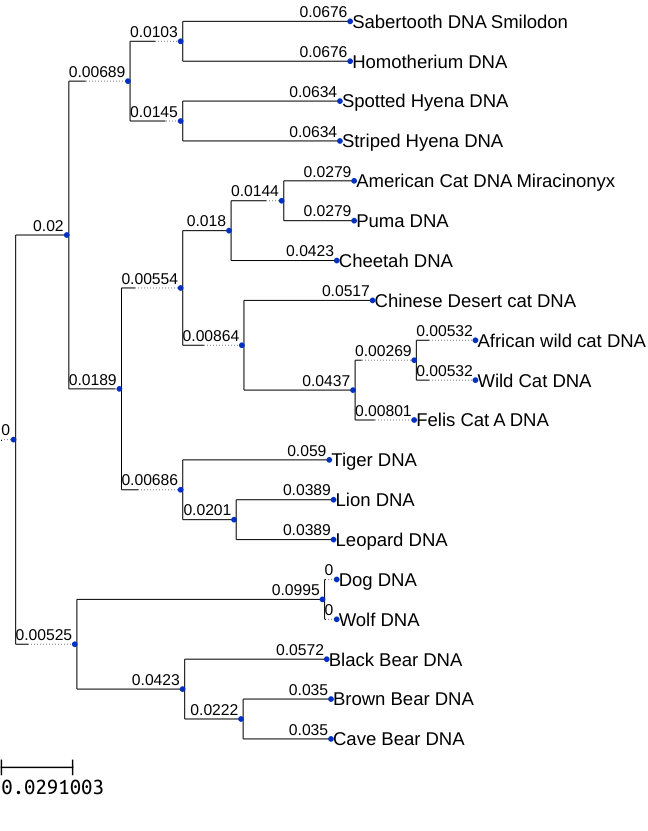

In [21]:
# Matrice des distances selon le fichier brut et Needlman-Wunsh
tree_fasta = upgma(M1, list(fasta.keys()))
print(tree_fasta)
t = Tree(tree_fasta)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

((((Sabertooth DNA Smilodon:0.08278809960280561,((((American Cat DNA Miracinonyx:0.033604559508632684,Puma DNA:0.033604559508632684):0.01356001658994968,Cheetah DNA:0.047164576098582364):0.016684399282430804,(Chinese Desert cat DNA:0.05557227842052118,((African wild cat DNA:0.0053192381219836545,Wild Cat DNA:0.0053192381219836545):0.0026892618316515897,Felis Cat A DNA:0.008008499953635244):0.04756377846688594):0.008276696960491985):0.010288298229520917,(Tiger DNA:0.05903300634370695,(Lion DNA:0.03892379763061633,Leopard DNA:0.03892379763061633):0.020109208713090618):0.015104267266827134):0.00865082599227153):0.011503331056240143,(Spotted Hyena DNA:0.06731573078150245,Striped Hyena DNA:0.06731573078150245):0.026975699877543308):0.020625672245585536,Homotherium DNA:0.1149171029046313):0.014580066468449185,((Dog DNA:0.0,Wolf DNA:0.0):0.1128050782157542,(Black Bear DNA:0.06948228399639578,(Brown Bear DNA:0.03503775249228635,Cave Bear DNA:0.03503775249228635):0.03444453150410943):0.04332279

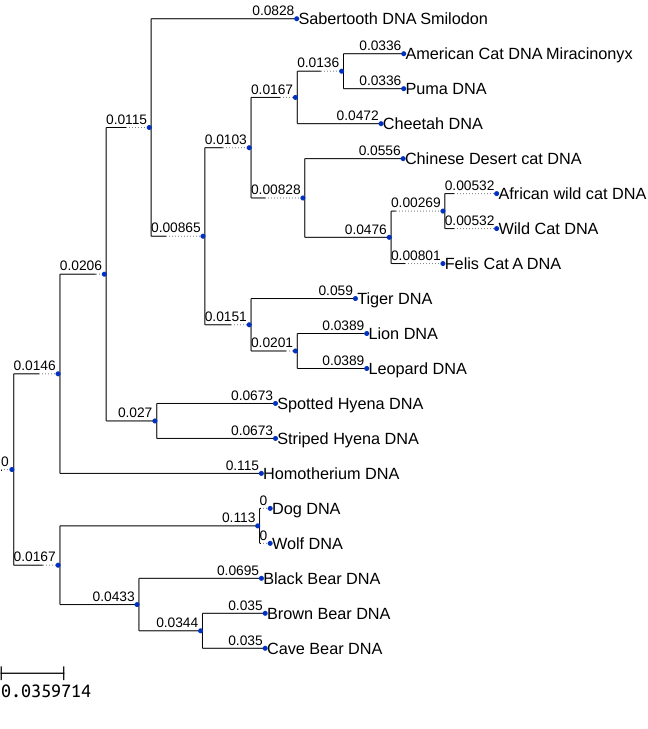

In [22]:
# Matrice des distances selon le fichier des séquences bien alignées
tree_fasta_align = upgma(M2, list(fasta_align.keys()))
print(tree_fasta_align)
t = Tree(tree_fasta_align)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

On remarque que les 2 méthodes de calcul des matrices de distance M1 et M2 donnent des résultats quasiment équivalents à quelques différences près.

**Exercice 9 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : L'hypothèse de l'horloge moléculaire, c'est-à-dire que les mutations génétiques s'accumulent de manière constante au cours du temps. Ici, cette hypothèse semble respectée car l'arbre phylogénétique final semble bien se calquer à la réalité (au résultat supposément attendu). Autre hypothèse : la matrice des distances se base sur des séquences alignées selon le meilleur alignement global. Ici, c'est le cas.

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 10 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

Réponse : L'enracinement par groupe extérieur, qui consite à enraciner l'arbre avec d'un côté le groupe étudié ici les félins et de l'autre un groupe extérieur qu'on sait éloigné génétiquement (mais pas trop), ici les canidés notamment. En réalité, les arbres obtenus sont déjà enracinés de cette manière. Donc il n'y a rien à faire de plus.

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 11 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

In [23]:
def neighbor_joining(M, lname):
    '''
    @param M: Matrice des distances dont triangle supérieur à 0.
    @param lname: Liste des noms de séquences
    @return: Arbre phylo format Newick str
    '''
    
    # Fonction d'accès à la case (i,j)
    # de la matrice M triangle bas même
    # si les indices ne sont pas donnés
    # dans le bon ordre
    def get_tril(i, j):
        if i > j:
            return M[i][j]
        else:
            return M[j][i]
    
    # Initalisation
    N = M.shape[0]
    # Pré-condition à respecter
    if N != len(lname) or N < 2:
        raise ValueError(f"N={N} != len(lname)={len(lname)} or N < 2")
        
    # Liste des sommes
    S = [0 for _ in range(N)]
    
    # Condition d'arrêt N = 2
    while N > 2:
        
        # Réinitialisation de S
        S = [0 for _ in range(N)]
        
        # Calcul des sommes
        for i in range(N):
            for j in range(N):
                if i > j:
                    S[i] += M[i][j]  
                    S[j] += M[i][j]        
        for i in range(N):
            S[i] /= (N - 2)
        
        # Calcul matrice intermédiaire
        P = np.full((N, N), np.inf)
        for i in range(N):
            for j in range(N):
                if i > j:
                    P[i][j] = M[i][j] - S[i] - S[j]
                    
        # Trouver le minimum de P
        (mini, minj) = np.unravel_index(np.argmin(P), (N, N))
        assert (mini > minj) # Invariant matrice triangle
        
        # Fonction de correction d'indice
        # Projection de Q -> M
        def correct(index):
            if index >= mini:
                return index + 1
            else:
                return index
        
        # Calcul des distances
        d1 = (M[mini][minj] / 2) + ((S[mini] - S[minj]) / 2)
        d2 = (M[mini][minj] / 2) + ((S[minj] - S[mini]) / 2)
        
        # Création du noeud
        lname[minj] = f"({lname[minj]}:{d2},{lname[mini]}:{d1})"
        lname.pop(mini)
        
        # Calcul de la nouvelle matrice
        N -= 1
        Q = np.full((N, N), np.inf)
        for i in range(N):
            for j in range(N):
                if i > j:
                    # Ligne case fusionnée
                    if minj == i:
                        jj = correct(j)
                        Q[i][j] = (get_tril(mini, jj) + get_tril(minj, jj) - get_tril(mini, minj)) / 2
                    # Colonne case fusionnée
                    elif minj == j:
                        ii = correct(i)
                        Q[i][j] = (get_tril(mini, ii) + get_tril(minj, ii) - get_tril(mini, minj)) / 2
                    else:
                        ii = correct(i)
                        jj = correct(j)
                        Q[i][j] = M[ii][jj]
        M = Q
        
    # N = 2
    # On enracine ici l'arbre mais on pourra le raciner
    # d'une autre manière par la suite au besoin
    d = M[1][0] / 2
    return f"({lname[0]}:{d},{lname[1]}:{d});"

In [24]:
M = np.array(
    [[0., 0.,   0., 0., 0., 0.],
     [5., 0.,   0., 0., 0., 0.],
     [4., 7.,   0., 0., 0., 0.],
     [7., 10.,  7., 0., 0., 0.],
     [6., 9.,   6., 5., 0., 0.],
     [8., 11.,  8., 9., 8., 0.]])
test = neighbor_joining(M, ["A", "B", "C", "D", "E", "F"])
print(test)

((((A:1.0,B:4.0):1.0,C:2.0):1.0,(D:3.0,E:2.0):1.0):2.5,F:2.5);


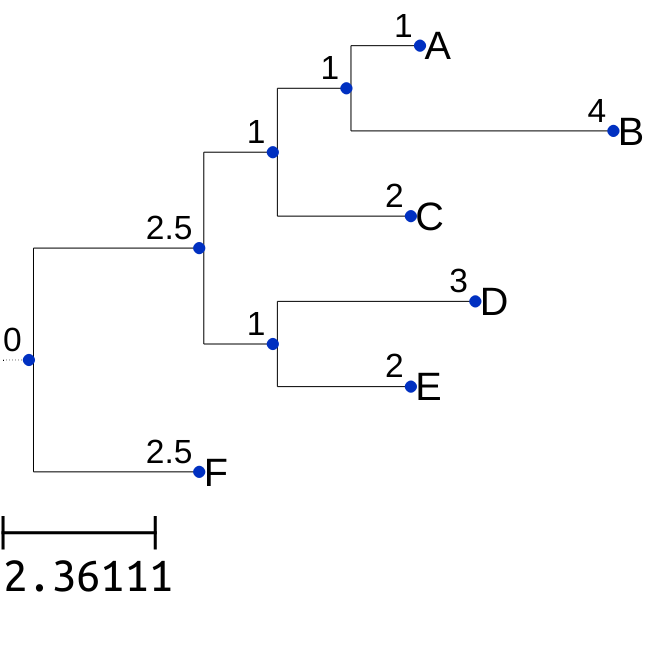

In [25]:
t = Tree(test)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

(((((Sabertooth DNA Smilodon:0.04988505295069999,Homotherium DNA:0.0852215335400668):0.011470653329075035,(Spotted Hyena DNA:0.056991096716208,Striped Hyena DNA:0.06974641256758723):0.013357039474757727):0.007215916652451627,((Dog DNA:0.0,Wolf DNA:0.0):0.10760935535679322,(Black Bear DNA:0.05562327432378618,(Brown Bear DNA:0.045174172974717756,Cave Bear DNA:0.02490133200985494):0.023729688206547764):0.03833231817595001):0.024909457960376167):0.01716286562605688,(((American Cat DNA Miracinonyx:0.01930032487604368,Puma DNA:0.03648746521532724):0.02163824862623869,Cheetah DNA:0.035125156778464194):0.01640613658659041,(Chinese Desert cat DNA:0.048945310873896586,(African wild cat DNA:0.004577769480976508,(Felis Cat A DNA:0.009043946671535116,Wild Cat DNA:0.005174488636925503):0.002540033239817015):0.04600155043300372):0.006033132113488347):0.0064926002724382675):0.0024536737389216218,(Tiger DNA:0.05399244076972815,(Lion DNA:0.03630493897726002,Leopard DNA:0.04154265628397265):0.02514977428

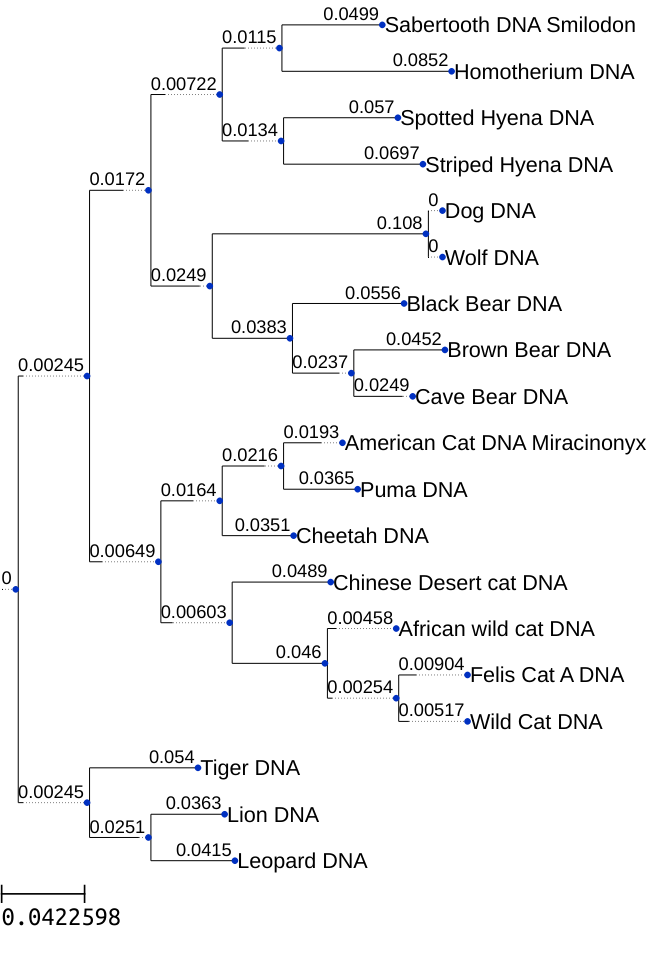

In [26]:
# Matrice des distances selon le fichier brut et Needlman-Wunsh
tree_fasta_nj = neighbor_joining(M1, list(fasta.keys()))
print(tree_fasta_nj)
t = Tree(tree_fasta_nj)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

(((((((Sabertooth DNA Smilodon:0.058803894737054094,Homotherium DNA:0.1242862197481051):0.013873359077336202,(Spotted Hyena DNA:0.060962884111487176,Striped Hyena DNA:0.07366857745151772):0.023256147898578085):0.002918992722343621,((Dog DNA:0.0,Wolf DNA:0.0):0.11032784982021394,(Black Bear DNA:0.060887844412459036,(Brown Bear DNA:0.04611519338668318,Cave Bear DNA:0.02396031159788952):0.04303897108804616):0.04540319588498247):0.05197820670967361):0.0180497866156586,(Tiger DNA:0.052340543560351414,(Lion DNA:0.036779440515205125,Leopard DNA:0.04106815474602754):0.026801671496446154):0.014353876010344359):0.009210677858901787,((American Cat DNA Miracinonyx:0.026747633059716003,Puma DNA:0.040461485957549365):0.014340104643213197,Cheetah DNA:0.04638448804531885):0.018181519673072622):0.0042123832245000575,Chinese Desert cat DNA:0.05278597385058309):0.024942248730509046,(African wild cat DNA:0.0045942720186668605,(Felis Cat A DNA:0.009167042259535046,Wild Cat DNA:0.005051393048925573):0.00252

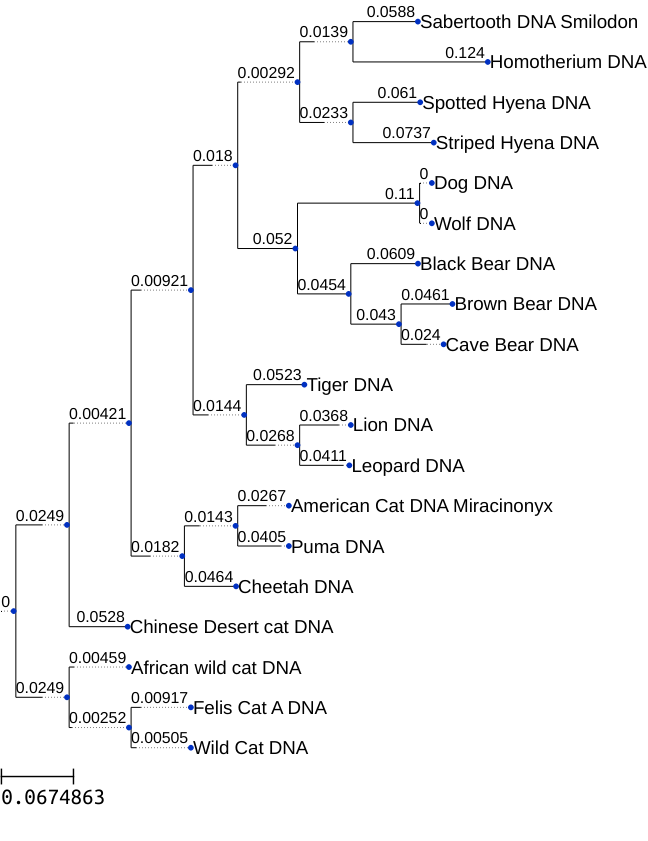

In [27]:
# Matrice des distances selon le fichier des séquences bien alignées
tree_fasta_align_nj = neighbor_joining(M2, list(fasta_align.keys()))
print(tree_fasta_align_nj)
t = Tree(tree_fasta_align_nj)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [28]:
# TODO: Réécrire l'arbre en l'enraçinant avec un groupe externe (pour le 2ème seulement)

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 12 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

In [66]:
def compute_bootstrap_matrix(fasta):
    """
    @param fasta: Dictionnaire des séquences alignées
    @return: Matrice initiale pour le bootstrap
    """
    seq = len(fasta)
    nucl = len(fasta[list(fasta.keys())[0]])
    R = np.full((seq, nucl), "", dtype=str)
    for i, k in enumerate(fasta.keys()):
        s = fasta[k]
        if len(s) != nucl:
            raise ValueError(f"len(fasta[{k}]) != (nucl == {nucl})")
        R[i] = np.array(list(s), dtype=str)
    return R

In [280]:
# Matrice de bootstrap initiale
B = compute_bootstrap_matrix(fasta_align)
B.shape

(19, 284)

In [84]:
import random
def bootstrap(B):
    """
    @param B: Matrice initiale pour le bootstrap
    @return: Matrice aléatoire de boostrap
    """
    (seq, nucl) = B.shape
    R = np.full((seq, nucl), "", dtype=str)
    for col in range(nucl):
        rand_nucl = random.randrange(0, nucl)
        R[:,col] = B[:,rand_nucl]
    return R

In [103]:
def bootstrap_to_fasta(B):
    """
    @param B: Matrice de bootstrap
    @return: Matrice convertie en un dictionnaire fasta
    """
    res = {}
    for i, k in enumerate(fasta.keys()):
        res[k] = "".join(B[i].tolist())
    return res

In [273]:
def compare_trees(A, B):
    """
    @param A, B: Arbres au format newick crées avec Tree()
    @return: nombre de branches identiques
    """
    def compare(A, B):
        """
        Parcours récursif préfixe des 2 arbres
        @return (nombre de branches identiques, _, _)
        """
        
        # Vérification des cas problématiques...
        if len(A.get_children()) > 2 or len(A.get_children()) == 1:
            raise ValueError("A is not a binary tree")
        if len(B.get_children()) > 2 or len(B.get_children()) == 1:
            raise ValueError("B is not a binary tree")
        
        # Match with des différents cas
        if A.is_leaf() and B.is_leaf():
            # On ne compte pas les branches qui mènent
            # directement à une feuille
            return (0, {A.name}, {B.name})
        
        # Les arbres n'ont pas la même structure
        elif A.is_leaf() and (not B.is_leaf()):
            subset = set()
            # On parcourt le restant de l'arbre B
            for node in B.traverse():
                if node.is_leaf():
                    subset.add(node.name)
            # On ne compte pas les branches qui mènent
            # directement à une feuille
            return (0, {A.name}, subset) 
        
        # Les arbres n'ont pas la même structure
        elif (not A.is_leaf()) and B.is_leaf():
            # On parcourt le restant de l'arbre A
            for node in A.traverse():
                subset = set()
                if node.is_leaf():
                    subset.add(node.name)
            # On ne compte pas les branches qui mènent
            # directement à une feuille
            return (0, subset, {B.name})
        
        elif (not A.is_leaf()) and (not B.is_leaf()):
            childA = A.get_children()
            childB = B.get_children()
            res = 0
            subset1 = set()
            subset2 = set()
            # On descend jusqu'aux feuilles dans le sous-arbre gauche
            # en faisant remonter le nombre de branches identiques r
            # et les sous-ensembles de taxons s1 et s2
            (r, s1, s2) = compare(childA[0], childB[0])
            res += r
            subset1.update(s1)
            subset2.update(s2)
            # Si sous-ensembles identiques la branche est identique
            if s1 == s2 and len(s1) > 0 and len(s2) > 0:
                res += 1
            # Idem pour le sous-arbre droit
            (r, s1, s2) = compare(childA[1], childB[1])
            res += r
            subset1.update(s1)
            subset2.update(s2)
            if s1 == s2 and len(s1) > 0 and len(s2) > 0:
                res += 1
            return (res, subset1, subset2)
        else:
            raise ValueError("Unknown error")
            
    return compare(A, B)[0]

In [276]:
A = Tree("(D, (C, (A, B)));")
B = Tree("(D, (B, (A, C)));")
same = compare_trees(A, B)
total = min(len(A.get_edges()) - 1, len(B.get_edges()) - 1)
print("same =", same)
print("total =", total)
print("ressemblance =", (same / total) * 100, "%")

same = 3
total = 6
ressemblance = 50.0 %


In [283]:
# Arbre UPGMA initial
BT = Tree(tree_fasta_align)
# -1 car la fonction compte la racine
total = len(BT.get_edges()) - 1

In [285]:
def bootstrap_algo(n_iter=100):
    """
    @param n_iter: Nombre de bootstrap sample à réaliser
    @return: Tableau des ressemblances (en %) entre les arbres
    """
    res = np.zeros(n_iter, dtype=float)
    for i in range(n_iter):
        # Création d'un sample bootstrap
        S = bootstrap(B)
        # Conversion vers un dictionnaire fasta
        fasta = bootstrap_to_fasta(S)
        # Calcul de la matrice de distances
        # Les séquences sont déjà alignées
        M = compute_distances(fasta, align=False)
        # Calcul de l'arbre avec UPGMA
        T = Tree(upgma(M, list(fasta_align.keys())))
        # Calcul du pourcentage de ressemblance
        res[i] = (compare_trees(BT, T) / total) * 100
    return res

In [291]:
results = bootstrap_algo()

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

M[13][2]=Dist(Leopard DNA, American Cat DNA Miracinonyx)
M[13][3]=Dist(Leopard DNA, Spotted Hyena DNA)
M[13][4]=Dist(Leopard DNA, Striped Hyena DNA)
M[13][5]=Dist(Leopard DNA, Chinese Desert cat DNA)
M[13][6]=Dist(Leopard DNA, African wild cat DNA)
M[13][7]=Dist(Leopard DNA, Felis Cat A DNA)
M[13][8]=Dist(Leopard DNA, Wild Cat DNA)
M[13][9]=Dist(Leopard DNA, Cheetah DNA)
M[13][10]=Dist(Leopard DNA, Puma DNA)
M[13][11]=Dist(Leopard DNA, Tiger DNA)
M[13][12]=Dist(Leopard DNA, Lion DNA)
M[14][0]=Dist(Dog DNA, Sabertooth DNA Smilodon)
M[14][1]=Dist(Dog DNA, Homotherium DNA)
M[14][2]=Dist(Dog DNA, American Cat DNA Miracinonyx)
M[14][3]=Dist(Dog DNA, Spotted Hyena DNA)
M[14][4]=Dist(Dog DNA, Striped Hyena DNA)
M[14][5]=Dist(Dog DNA, Chinese Desert cat DNA)
M[14][6]=Dist(Dog DNA, African wild cat DNA)
M[14][7]=Dist(Dog DNA, Felis Cat A DNA)
M[14][8]=Dist(Dog DNA, Wild Cat DNA)
M[14][9]=Dist(Dog DNA, Cheetah DNA)
M[14][10]=Dist(Dog DNA, Puma DNA)
M[14][11]=Dist(Dog DNA, Tiger DNA)
M[14][12]=Di

M[6][2]=Dist(African wild cat DNA, American Cat DNA Miracinonyx)
M[6][3]=Dist(African wild cat DNA, Spotted Hyena DNA)
M[6][4]=Dist(African wild cat DNA, Striped Hyena DNA)
M[6][5]=Dist(African wild cat DNA, Chinese Desert cat DNA)
M[7][0]=Dist(Felis Cat A DNA, Sabertooth DNA Smilodon)
M[7][1]=Dist(Felis Cat A DNA, Homotherium DNA)
M[7][2]=Dist(Felis Cat A DNA, American Cat DNA Miracinonyx)
M[7][3]=Dist(Felis Cat A DNA, Spotted Hyena DNA)
M[7][4]=Dist(Felis Cat A DNA, Striped Hyena DNA)
M[7][5]=Dist(Felis Cat A DNA, Chinese Desert cat DNA)
M[7][6]=Dist(Felis Cat A DNA, African wild cat DNA)
M[8][0]=Dist(Wild Cat DNA, Sabertooth DNA Smilodon)
M[8][1]=Dist(Wild Cat DNA, Homotherium DNA)
M[8][2]=Dist(Wild Cat DNA, American Cat DNA Miracinonyx)
M[8][3]=Dist(Wild Cat DNA, Spotted Hyena DNA)
M[8][4]=Dist(Wild Cat DNA, Striped Hyena DNA)
M[8][5]=Dist(Wild Cat DNA, Chinese Desert cat DNA)
M[8][6]=Dist(Wild Cat DNA, African wild cat DNA)
M[8][7]=Dist(Wild Cat DNA, Felis Cat A DNA)
M[9][0]=Dist(

M[15][0]=Dist(Wolf DNA, Sabertooth DNA Smilodon)
M[15][1]=Dist(Wolf DNA, Homotherium DNA)
M[15][2]=Dist(Wolf DNA, American Cat DNA Miracinonyx)
M[15][3]=Dist(Wolf DNA, Spotted Hyena DNA)
M[15][4]=Dist(Wolf DNA, Striped Hyena DNA)
M[15][5]=Dist(Wolf DNA, Chinese Desert cat DNA)
M[15][6]=Dist(Wolf DNA, African wild cat DNA)
M[15][7]=Dist(Wolf DNA, Felis Cat A DNA)
M[15][8]=Dist(Wolf DNA, Wild Cat DNA)
M[15][9]=Dist(Wolf DNA, Cheetah DNA)
M[15][10]=Dist(Wolf DNA, Puma DNA)
M[15][11]=Dist(Wolf DNA, Tiger DNA)
M[15][12]=Dist(Wolf DNA, Lion DNA)
M[15][13]=Dist(Wolf DNA, Leopard DNA)
M[15][14]=Dist(Wolf DNA, Dog DNA)
M[16][0]=Dist(Black Bear DNA, Sabertooth DNA Smilodon)
M[16][1]=Dist(Black Bear DNA, Homotherium DNA)
M[16][2]=Dist(Black Bear DNA, American Cat DNA Miracinonyx)
M[16][3]=Dist(Black Bear DNA, Spotted Hyena DNA)
M[16][4]=Dist(Black Bear DNA, Striped Hyena DNA)
M[16][5]=Dist(Black Bear DNA, Chinese Desert cat DNA)
M[16][6]=Dist(Black Bear DNA, African wild cat DNA)
M[16][7]=Dist(Bl

M[15][9]=Dist(Wolf DNA, Cheetah DNA)
M[15][10]=Dist(Wolf DNA, Puma DNA)
M[15][11]=Dist(Wolf DNA, Tiger DNA)
M[15][12]=Dist(Wolf DNA, Lion DNA)
M[15][13]=Dist(Wolf DNA, Leopard DNA)
M[15][14]=Dist(Wolf DNA, Dog DNA)
M[16][0]=Dist(Black Bear DNA, Sabertooth DNA Smilodon)
M[16][1]=Dist(Black Bear DNA, Homotherium DNA)
M[16][2]=Dist(Black Bear DNA, American Cat DNA Miracinonyx)
M[16][3]=Dist(Black Bear DNA, Spotted Hyena DNA)
M[16][4]=Dist(Black Bear DNA, Striped Hyena DNA)
M[16][5]=Dist(Black Bear DNA, Chinese Desert cat DNA)
M[16][6]=Dist(Black Bear DNA, African wild cat DNA)
M[16][7]=Dist(Black Bear DNA, Felis Cat A DNA)
M[16][8]=Dist(Black Bear DNA, Wild Cat DNA)
M[16][9]=Dist(Black Bear DNA, Cheetah DNA)
M[16][10]=Dist(Black Bear DNA, Puma DNA)
M[16][11]=Dist(Black Bear DNA, Tiger DNA)
M[16][12]=Dist(Black Bear DNA, Lion DNA)
M[16][13]=Dist(Black Bear DNA, Leopard DNA)
M[16][14]=Dist(Black Bear DNA, Dog DNA)
M[16][15]=Dist(Black Bear DNA, Wolf DNA)
M[17][0]=Dist(Brown Bear DNA, Sabert

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

M[17][6]=Dist(Brown Bear DNA, African wild cat DNA)
M[17][7]=Dist(Brown Bear DNA, Felis Cat A DNA)
M[17][8]=Dist(Brown Bear DNA, Wild Cat DNA)
M[17][9]=Dist(Brown Bear DNA, Cheetah DNA)
M[17][10]=Dist(Brown Bear DNA, Puma DNA)
M[17][11]=Dist(Brown Bear DNA, Tiger DNA)
M[17][12]=Dist(Brown Bear DNA, Lion DNA)
M[17][13]=Dist(Brown Bear DNA, Leopard DNA)
M[17][14]=Dist(Brown Bear DNA, Dog DNA)
M[17][15]=Dist(Brown Bear DNA, Wolf DNA)
M[17][16]=Dist(Brown Bear DNA, Black Bear DNA)
M[18][0]=Dist(Cave Bear DNA, Sabertooth DNA Smilodon)
M[18][1]=Dist(Cave Bear DNA, Homotherium DNA)
M[18][2]=Dist(Cave Bear DNA, American Cat DNA Miracinonyx)
M[18][3]=Dist(Cave Bear DNA, Spotted Hyena DNA)
M[18][4]=Dist(Cave Bear DNA, Striped Hyena DNA)
M[18][5]=Dist(Cave Bear DNA, Chinese Desert cat DNA)
M[18][6]=Dist(Cave Bear DNA, African wild cat DNA)
M[18][7]=Dist(Cave Bear DNA, Felis Cat A DNA)
M[18][8]=Dist(Cave Bear DNA, Wild Cat DNA)
M[18][9]=Dist(Cave Bear DNA, Cheetah DNA)
M[18][10]=Dist(Cave Bear DNA

M[18][12]=Dist(Cave Bear DNA, Lion DNA)
M[18][13]=Dist(Cave Bear DNA, Leopard DNA)
M[18][14]=Dist(Cave Bear DNA, Dog DNA)
M[18][15]=Dist(Cave Bear DNA, Wolf DNA)
M[18][16]=Dist(Cave Bear DNA, Black Bear DNA)
M[18][17]=Dist(Cave Bear DNA, Brown Bear DNA)
M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miraci

M[15][6]=Dist(Wolf DNA, African wild cat DNA)
M[15][7]=Dist(Wolf DNA, Felis Cat A DNA)
M[15][8]=Dist(Wolf DNA, Wild Cat DNA)
M[15][9]=Dist(Wolf DNA, Cheetah DNA)
M[15][10]=Dist(Wolf DNA, Puma DNA)
M[15][11]=Dist(Wolf DNA, Tiger DNA)
M[15][12]=Dist(Wolf DNA, Lion DNA)
M[15][13]=Dist(Wolf DNA, Leopard DNA)
M[15][14]=Dist(Wolf DNA, Dog DNA)
M[16][0]=Dist(Black Bear DNA, Sabertooth DNA Smilodon)
M[16][1]=Dist(Black Bear DNA, Homotherium DNA)
M[16][2]=Dist(Black Bear DNA, American Cat DNA Miracinonyx)
M[16][3]=Dist(Black Bear DNA, Spotted Hyena DNA)
M[16][4]=Dist(Black Bear DNA, Striped Hyena DNA)
M[16][5]=Dist(Black Bear DNA, Chinese Desert cat DNA)
M[16][6]=Dist(Black Bear DNA, African wild cat DNA)
M[16][7]=Dist(Black Bear DNA, Felis Cat A DNA)
M[16][8]=Dist(Black Bear DNA, Wild Cat DNA)
M[16][9]=Dist(Black Bear DNA, Cheetah DNA)
M[16][10]=Dist(Black Bear DNA, Puma DNA)
M[16][11]=Dist(Black Bear DNA, Tiger DNA)
M[16][12]=Dist(Black Bear DNA, Lion DNA)
M[16][13]=Dist(Black Bear DNA, Leopa

M[11][0]=Dist(Tiger DNA, Sabertooth DNA Smilodon)
M[11][1]=Dist(Tiger DNA, Homotherium DNA)
M[11][2]=Dist(Tiger DNA, American Cat DNA Miracinonyx)
M[11][3]=Dist(Tiger DNA, Spotted Hyena DNA)
M[11][4]=Dist(Tiger DNA, Striped Hyena DNA)
M[11][5]=Dist(Tiger DNA, Chinese Desert cat DNA)
M[11][6]=Dist(Tiger DNA, African wild cat DNA)
M[11][7]=Dist(Tiger DNA, Felis Cat A DNA)
M[11][8]=Dist(Tiger DNA, Wild Cat DNA)
M[11][9]=Dist(Tiger DNA, Cheetah DNA)
M[11][10]=Dist(Tiger DNA, Puma DNA)
M[12][0]=Dist(Lion DNA, Sabertooth DNA Smilodon)
M[12][1]=Dist(Lion DNA, Homotherium DNA)
M[12][2]=Dist(Lion DNA, American Cat DNA Miracinonyx)
M[12][3]=Dist(Lion DNA, Spotted Hyena DNA)
M[12][4]=Dist(Lion DNA, Striped Hyena DNA)
M[12][5]=Dist(Lion DNA, Chinese Desert cat DNA)
M[12][6]=Dist(Lion DNA, African wild cat DNA)
M[12][7]=Dist(Lion DNA, Felis Cat A DNA)
M[12][8]=Dist(Lion DNA, Wild Cat DNA)
M[12][9]=Dist(Lion DNA, Cheetah DNA)
M[12][10]=Dist(Lion DNA, Puma DNA)
M[12][11]=Dist(Lion DNA, Tiger DNA)
M[1

M[14][8]=Dist(Dog DNA, Wild Cat DNA)
M[14][9]=Dist(Dog DNA, Cheetah DNA)
M[14][10]=Dist(Dog DNA, Puma DNA)
M[14][11]=Dist(Dog DNA, Tiger DNA)
M[14][12]=Dist(Dog DNA, Lion DNA)
M[14][13]=Dist(Dog DNA, Leopard DNA)
M[15][0]=Dist(Wolf DNA, Sabertooth DNA Smilodon)
M[15][1]=Dist(Wolf DNA, Homotherium DNA)
M[15][2]=Dist(Wolf DNA, American Cat DNA Miracinonyx)
M[15][3]=Dist(Wolf DNA, Spotted Hyena DNA)
M[15][4]=Dist(Wolf DNA, Striped Hyena DNA)
M[15][5]=Dist(Wolf DNA, Chinese Desert cat DNA)
M[15][6]=Dist(Wolf DNA, African wild cat DNA)
M[15][7]=Dist(Wolf DNA, Felis Cat A DNA)
M[15][8]=Dist(Wolf DNA, Wild Cat DNA)
M[15][9]=Dist(Wolf DNA, Cheetah DNA)
M[15][10]=Dist(Wolf DNA, Puma DNA)
M[15][11]=Dist(Wolf DNA, Tiger DNA)
M[15][12]=Dist(Wolf DNA, Lion DNA)
M[15][13]=Dist(Wolf DNA, Leopard DNA)
M[15][14]=Dist(Wolf DNA, Dog DNA)
M[16][0]=Dist(Black Bear DNA, Sabertooth DNA Smilodon)
M[16][1]=Dist(Black Bear DNA, Homotherium DNA)
M[16][2]=Dist(Black Bear DNA, American Cat DNA Miracinonyx)
M[16][3

In [290]:
print(results)
print("moyenne =", results.mean(),"%")

[38.88888889 25.         38.88888889 38.88888889 36.11111111 33.33333333
  8.33333333  2.77777778  2.77777778 36.11111111  5.55555556 50.
 25.          8.33333333 36.11111111 36.11111111 11.11111111 50.
  0.         27.77777778 44.44444444  5.55555556 41.66666667  5.55555556
 50.         22.22222222 36.11111111 19.44444444 36.11111111  0.
 36.11111111 25.         38.88888889 33.33333333 38.88888889 30.55555556
 25.         38.88888889 27.77777778 36.11111111 44.44444444 30.55555556
  5.55555556  5.55555556 13.88888889 27.77777778 36.11111111  0.
 36.11111111 38.88888889 50.         25.         19.44444444 25.
 36.11111111 33.33333333 25.         44.44444444  2.77777778 61.11111111
 38.88888889 77.77777778 36.11111111 30.55555556 27.77777778  8.33333333
 33.33333333 36.11111111 44.44444444 25.         27.77777778 36.11111111
  2.77777778 30.55555556  0.         38.88888889 36.11111111 33.33333333
 50.         30.55555556 44.44444444  2.77777778 25.         16.66666667
 36.11111111 33.33

On obtient en moyenne 28.8% de ressemblance, ce qui indiquerait en toute logique que nos branches sont assez peu robustes. Ou alors peut-être que la méthode de comparaison d'arbre est erronée.

----
## Conclusion

**Exercice 13 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de *smilodon*, *homotherium* et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse : Pour cette analyse, nous n'allons considérer que les arbres obtenus à l'aide du fichier fasta avec les séquences déjà bien alignées.